### Imports & Settings

In [1]:
from collections import Counter
import time
import numpy as np
import pandas as pd
import nn_model as nn
from utils import *
from utils import properties as p
import hashlib
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import f1_score
from metrics import *
from IPython.display import display
import time

In [2]:
from noknow.core import ZK, ZKSignature, ZKParameters, ZKData, ZKProof
import copy

In [3]:
%load_ext jupyternotify
import warnings
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

### Parameters

In [4]:
epochs_n = 1
learning_rate = 0.1
seed = 19101995

features = {
    'ETHNICITY': ['Asian', 'Black', 'Indian', 'White'],
    'GENDER': ['Female', 'Male']
}

not_features = {
    'ETHNICITY': ['ROCK', 'PAPER', 'SCISSORS', 'UNCATEGORIZED'],
    'GENDER': ['ZERO', 'ONE']
}

p.update({
    
    'age_min' : 0,
    'age_max' : 39,
    
    'data_samples' : 300,  
    'privileged_group_proportion': 0.85,
    
    'enable_zk': False,
    
    'gap': 0.05,
    'max_gap': 1,
    
    
})

### ZKP Server

In [5]:
class ZKServer:
    def __init__(self, password, features):
        self.password = password
        self.features = features
        self.client_representations = {}
        self.tokens = {}
        self.initialized_zk_features = False
        
        for el in features:
            self.client_representations[el] = []
            self.tokens[el] = []
        self.zk = ZK.new(curve_name="secp384r1", hash_alg="sha3_512")
        self.signature: ZKSignature = self.zk.create_signature(password)
            
        self.groups = {}
        for f in self.features:
            self.groups[f] = Counter()
            
    def load_client_signature(self, signature):
        #load client signature
        client_signature = ZKSignature.load(signature)
        return ZK(client_signature.params)
    
    def create_token(self, feature, signature):
        #load client signature
        client_signature = ZKSignature.load(signature)
        client_zk = ZK(client_signature.params)
        # Create a signed token and send to the client
        token = self.zk.sign(self.password, client_zk.token()).dump(separator=":")
        self.tokens[feature] += [token]
        self.client_representations[feature] += [{'signature' : client_signature, 'zk' : client_zk}]
        assert token in self.tokens[feature]
        return token
        
    def verify_clients(self, feature, signature):
        # Get the token from the client
        proof = ZKData.load(signature)
        token = ZKData.load(proof.data, ":")
        
        proofs = []
        # In this example, the server signs the token so it can be sure it has not been modified
        for label in self.client_representations[feature]:
            client_signature = label['signature']
            client_zk = label['zk']
            proofs += [self.verify_client(proof, token, client_signature, client_zk)]
            
        return sum(proofs) >= 1
    
    def verify_client(self, proof, token, client_signature, client_zk):
        return self.zk.verify(token, self.signature) and \
                client_zk.verify(proof, client_signature, data=token)
    
    def verify(self, feature, signatures):
        return sum([self.verify_clients(feature, s) for s in signatures]) >= 1
    
    def get_features_permutation(self):
        balanced = []
        for f in self.encrypted_features_dict:
            balanced += [self.encrypted_features_dict[f]]
        return list(itertools.product(*balanced))
    
    def init_zk(self, clients):
        if self.initialized_zk_features:
            print('Server already initialized')
            return
        
        feature_dict = {}
        
        for c in clients:
            self.create_token(c.feature, c.signature)
            
            if c.feature not in feature_dict:
                feature_dict[c.feature] = [{'feature': c.feature, 'label': c.encrypt_label()}]
            else:
                feature_dict[c.feature] += [{'feature': c.feature, 'label': c.encrypt_label()}]
        
        self.encrypted_features_dict = feature_dict
        
        permutations = self.get_features_permutation()
                
        for individual in permutations:
            for feat in individual:
                self.groups[feat['feature']].update({feat['label']: 1})
        self.initialized_zk_features = True

### ZKP Client

In [6]:
class ZKClient:
    def __init__(self, feature, label):
        self.zk = ZK.new(curve_name="secp256k1", hash_alg="sha3_256")
        self.label = label
        self.feature = feature
        # Create signature and send to server
        self.signature = self.zk.create_signature(label).dump()
        
    def set_label(self, label):
        self.label = label
        self.signature = self.zk.create_signature(label).dump()
            
    def create_proof(self, server_token):
        # Create a proof that signs the provided token and sends to server
        proof = self.zk.sign(self.label, server_token).dump()
        return proof
    
    def create_proofs(self, server_tokens):
        return [self.create_proof(t) for t in server_tokens]
    
    def encrypt_label(self, encrypt=True):
        #Create a secret hash
        secret = hashlib.sha256()
        #use the zk client salt value to encrypt the string
        encrypted_label = self.label + str(self.zk.params.s)
        #create the hash
        secret.update(encrypted_label.encode('utf-8'))
        
        if encrypt:
            return secret.hexdigest()
        else:
            return self.label #TESTING ONLY

### Server Initializer

In [7]:
class ServerInitializer:
    def __init__(self, features, client_prototype):
        self.client_prototype = client_prototype
        self.features = features
        
    def create_clients(self):
        clients = []
        for feature in self.features:
            for label in self.features[feature]:
                client = copy.copy(self.client_prototype)
                client.feature = feature
                client.set_label(label)
                clients += [client]
        return clients

### Client Initializer

In [8]:
class ClientInitializer:
    def __init__(self):
        self.generated = False
    def generate_client_prototype(self):
        if not self.generated:
            self.generated = True
            return ZKClient('', '')

### Model classes

In [9]:
#Server 
class FairServer(ZKServer):
    def __init__(self, password, features, model, max_gap, gap, self_balancing=True):
        super().__init__(password, features)
        self.self_balancing = self_balancing
        self.model = LearningModel(model)
        self.workers = []
        self.queue = {}
        self.max_gap = max_gap
        self.gap = gap
        
        
    def register_worker(self, worker):
        #if self.zk_authenticate(worker):
        self.workers += [worker]
        
    def register_feature_group(self, feature, label):
        self.groups[feature].update({label : 1})

    def is_balanced(self, feature, label):
        if len(self.groups[feature]) == 0:
            return True
        count = sum(count for n, count in self.groups[feature].items())
        avg = count / len(self.groups[feature])
        calc_gap = (self.groups[feature][label] + 1) - avg
        #print(calc_gap/avg, calc_gap)
        return (calc_gap / avg) <= self.gap or calc_gap <= self.max_gap
    
    def send_model(self, worker):
        worker.load_model(self.model)
        
    def balanced_update(self, features):
        #if self balancin is disabled return true
        if not self.self_balancing:
            return True
        
        return len(features) == sum([
            self.is_balanced(list(f.keys())[0], list(f.values())[0])
            for f 
            in features
        ])
    
    def get_features_key_values(self, f):
        return list(f.keys())[0], list(f.values())[0]
        
    def enqueue_worker(self, w_id, features):
        labels = 0
        for f in features: 
            k, v = self.get_features_key_values(f)
            labels += int(v, 16) #hex
        if str(labels) not in self.queue:
            self.queue[str(labels)] = [w_id]
        else:
            self.queue[str(labels)] += [w_id]
    
    def load_update(self, w_id, features, weights):
        if not self.balanced_update(features):
            #print('Unbalanced id: ' + str(w_id))
            self.enqueue_worker(w_id, features)
            return
        for f in features:
            k, v = self.get_features_key_values(f)
            self.register_feature_group(k, v)
        self.model.set_weights(weights)
        
    def request_training(self, w):
        w.train()
        
    def zk_authenticate(self, w):
        #ZKP Authentication
        verification = [
            self.verify_clients(f, w.zkp_clients[f].create_proof(self.tokens[f][0]))
            for f in self.features                                    
        ]
        auth = sum(verification) == len(self.features)
        #print(('' if auth else 'Un') + 'authorized')
        return auth
    
    def get_next_possible_updates(self):
        possible = []
        permutation = self.get_features_permutation()
        for individual in permutation:
            bal = [self.is_balanced(feat['feature'], feat['label']) for feat in individual]
            if False not in bal:
                possible += [individual]
        return possible
    
    def get_possible_queues(self):
        possible_updates = self.get_next_possible_updates()
        queue_ids = []
        for individual in possible_updates:
            queue_ids += [str(sum([int(feat['label'], 16) for feat in individual]))]
        return queue_ids
    
    def get_possible_workers(self):
        q_ids = self.get_possible_queues()
        possible_ids = [
            q_id 
            for q_id in q_ids 
            if q_id in self.queue and len(self.queue[q_id]) != 0
        ]
        return self.queue[possible_ids[0]] if len(possible_ids) != 0 else []
    
    def get_worker(self, w_id):
        return next(filter(lambda w: w.id == w_id, self.workers))
    
    def train(self):
        #Sequential train of workers
        for w in self.workers:
            self.send_model(w)
            self.request_training(w)
        
        #Balance the rest of the workers
        possible_workers = self.get_possible_workers()
        while len(possible_workers) != 0:
            w_id = possible_workers.pop()
            w = self.get_worker(w_id)
            self.send_model(w)
            self.request_training(w)
            possible_workers = self.get_possible_workers()
        
    def fair_metrics(self):
        return 'Fair metrics: '
    
    def predict(self, x):
        return self.model.predict(x)
    
    def plot_hist(self, feature):
        plt.title(feature)
        x = np.arange(len(self.groups[feature]))
        y = [self.groups[feature][value] for value in self.groups[feature]]
        plt.bar(x, height=y)
        plt.xticks([])
        plt.ylabel("Probability")
        plt.xlabel("Data")
        plt.show()
        
    def count_updates(self):
        if len(self.features) <= 0:
            return 0
        return sum(self.features[list(self.features.keys())[0]])
        
        
        
    def plot_hists(self, name):
        fig, axs = plt.subplots(
            1, len(self.features), 
            sharey=True, tight_layout=True, 
            figsize=(8, 4)
        )
        
        for f, i in zip(self.features.keys(), range(len(self.features))):
            axs[i].title.set_text(f)
            x = np.arange(len(self.groups[f]))
            y = [self.groups[f][value] for value in self.groups[f]]
            axs[i].bar(x, height=y)
            axs[i].set_xticks([], minor=False)
            axs[i].set_ylabel("Probability")
            axs[i].set_xlabel("Data")
            s = sum(y)
            
        fig.suptitle(name + f', #records: {s}')
        plt.show()
        

In [10]:
#Worker 
class Worker:
    #secret_features must of the form {'f_name_1': 'f_value_1', 'f_name_2': 'f_value_2', ...}
    def __init__(self, id_w, zkp_client_prototype, server, x, y, secret_features, encrypt=True):
        self.id = id_w
        self.zkp_client_prototype = zkp_client_prototype
        self.server = server
        self.model = {}
        self.x = x
        self.y = y
        self.secret_features = secret_features
        self.encrypt = encrypt
        self.zkp_clients = {}
        for f in secret_features.keys():
            c = copy.copy(zkp_client_prototype)
            c.feature = f
            c.set_label(secret_features[f])
            self.zkp_clients[f] = c
        
    def send_registration(self):
        self.server.register_worker(self)
        
    def prepare_features(self):
        feature_to_send = []
        for k in self.zkp_clients.keys():
            c = self.zkp_clients[k]
            secret = c.encrypt_label(self.encrypt)
            feature_to_send += [{c.feature: secret}]
        return feature_to_send
                    
    def load_model(self, model):
        self.model = model
        
    def send_update(self, features, weights):
        self.server.load_update(self.id, features, weights)
        
    def train(self):
        self.model.train(self.x, self.y)
        features = self.prepare_features()
        weights = self.model.get_weights()
        self.send_update(features, weights)

In [11]:
class LearningModel:
    def __init__(self, model, epochs=epochs_n, learning_rate=learning_rate):
        self.model = model
        self.epochs = epochs
        self.learning_rate = learning_rate
    
    def set_weights(self, W):
        self.model.load_weights(W)
        
    def get_weights(self):
        return self.model.get_weights()
    
    def train(self, X, y):
        self.model.fit(X, y, self.epochs, self.learning_rate)
    
    def predict(self, x):
        return self.model.predict(x)

### ZKP-FED-Framework

In [12]:
class ZKPFEDFramework:
    def __init__(self, features, not_features, gap=0.05, max_gap=5, data=[], self_balancing=True):
        self.self_balancing = self_balancing
        self.client_prototype = ClientInitializer().generate_client_prototype()
        self.features = features
        self.not_features = not_features #TESTING
        self.server_initializer = ServerInitializer(features, self.client_prototype)
        self.gap = gap
        self.max_gap = max_gap

        #self.test_server()
        
        
    #ZKP Assertions
    def test_server(self):
        #Create a mock server initializer with actual features
        si_f = ServerInitializer(self.features, self.client_prototype)
        
        #Create a mock server initializer with unauthorized features (not_features)
        si_n = ServerInitializer(self.not_features, self.client_prototype)
        
        #Create a mock server
        server = ZKServer('password', features)
        
        #Register authrized clients in the mock server
        server.init_zk(si_f.create_clients())
        
        #Create proofs for authorized users
        mock_clients_f = si_f.create_clients()
        proofs_f = [server.verify(c.feature, c.create_proofs(server.tokens[c.feature])) 
                  for c 
                  in mock_clients_f]
        
        #Create proofs for unauthorized users
        mock_clients_n = si_n.create_clients()
        proofs_n = [server.verify_clients(c.feature, c.create_proof(server.tokens[c.feature][0])) 
                  for c 
                  in mock_clients_n]
        
        #Assert that all the registered clients get access to the server
        assert sum(proofs_f) == len(mock_clients_f)
        
        #Assert that none of the non-registered clients get access to the server
        assert sum(proofs_n) == 0
        
    #Create a server
    def create_server(self, model):
        fs = FairServer('password', features, model, gap=self.gap, max_gap=self.max_gap, self_balancing=self.self_balancing)
        fs.init_zk(self.server_initializer.create_clients())
        return fs
    
    #Create workers
    def create_workers(self, server, X, y, secret_features):
        return [Worker(i, self.client_prototype, server, X[i], y[i], secret_features[i]) for i in range(len(X))]

    #Register all workers
    def register_workers(self, workers):
        for worker in workers:
            worker.send_registration()

    def start_training(self, server):
        start_train = time.time()
        server.train()
        end_train = time.time()
        #print('Training time:' + str(end_train - start_train))

    def zkp_fed_training(self, model, X, y, secret):
        start = tm()
        s = self.create_server(model)
        end = tm()
        print(f'Server ready in {end - start}s')
        start = tm()
        ws = self.create_workers(s, X, y, secret)
        end = tm()
        print(f'Workers ready in {end - start}s')
        start = tm()
        self.register_workers(ws)
        end = tm()
        print(f'Workers registred in {end - start}s')
        start = tm()
        self.start_training(s)
        end = tm()
        print(f'Training complete in {end - start}s')
        #print(s.fair_metrics())
        return s#, ws

## Evaluation

### Model for reference

In [13]:
mult_fact = 2

In [14]:
# network (not federated)
net = nn.get_3l_nn(2, 2, 1)

X = np.array([[[[0, 0]]], [[[0, 1]]], [[[1, 0]]], [[[1, 1]]]] * mult_fact)
y = np.array([[[[0]]], [[[1]]], [[[1]]], [[[0]]]] * mult_fact)

#train
for i in range(len(X)):
    net.fit(X[i], y[i], epochs=epochs_n, learning_rate=learning_rate)

# test
out = net.predict(X)

### Model for Fed-Learning

In [15]:
X = np.array([[[[0, 0]]], [[[0, 1]]], [[[1, 0]]], [[[1, 1]]], [[[1, 2]]]] * mult_fact)
y = np.array([[[[0]]], [[[1]]], [[[1]]], [[[0]]], [[[2]]]] * mult_fact)

zkp_fed_framework = ZKPFEDFramework(features, not_features, gap=100, max_gap=mult_fact*100)
# network (for federated learning)
net2 = nn.get_3l_nn(2, 2, 1)

feature_groups = [
    {
        'ETHNICITY': get_rnd_ethnicity(),
        'GENDER': get_rnd_gender()
    } for _ in range(int(len(X)/mult_fact) - 1)] + [
    {
        'ETHNICITY': 'unauthorized',
        'GENDER': get_rnd_gender()
    }
]

feature_groups *= mult_fact

#train
#s = zkp_fed_framework.zkp_fed_training(net2, X, y, feature_groups)

#test
#out2 = s.predict([w.x for w in s.workers])

### Test if the 2 models behave in the same way

In [16]:
#assert np.array_equal(out, out2)

### Test if workers retain features

In [17]:
def test_features(z_fed):
    w_groups = [w.secret_features for w in z_fed.s.workers] 
    test_groups = {}

    salt = z_fed.client_prototype.zk.params.s

    for f in features:
        test_groups[f] = Counter()

    for t in w_groups:
        for f in t.keys():
            secret = hashlib.sha256()
            label = t[f] + str(salt)
            secret.update(label.encode('utf-8'))
            label = secret.hexdigest()
            test_groups[f].update({label : 1})

    #check if the two counters are equal
    assert test_groups == z_fed.s.groups

## Usage

### Read data

In [18]:
df = pd.read_csv('../dataset/data.csv')

### Clean data

In [19]:
#Remove other ethnicities
del p['ETHNICITIES'][4]
df = df[df['ethnicity'] != 4]
#print_summary(df)

In [20]:
def age_filter(df, age_min, age_max):
    return (df['age'] >= age_min) & (df['age'] <= age_max)

def ethnicity_gender_filter(df, i, j):
    return (df['ethnicity'] == p['ETHNICITIES'][i]) & (df['gender'] == p['GENDERS'][j])

def ethnicity_age_filter(df, e, age_min, age_max):
    return (df['ethnicity'] == p['ETHNICITIES'][e]) & age_filter(df, age_min, age_max)

def ethnicity_gender_age_filter(df, i, j, age_min, age_max):
    return ethnicity_gender_filter(df, i, j) & age_filter(df, age_min, age_max)

In [21]:
#Prepare
df = df.loc[age_filter(df, p['age_min'], p['age_max'])]
df['ethnicity'] = df['ethnicity'].map(p['ETHNICITIES'])
df['gender'] = df['gender'].map(p['GENDERS'])

### Create balanced test dataset

In [22]:
#Ethnicity gender age sample size
ethnicity_age_sample_size = round(p['data_samples'] / (round(p['age_range']() / p['age_bins']) * len(p['ETHNICITIES'])))

balanced_df = pd.concat([
    df.loc[ethnicity_age_filter(df, e, age_m, age_M)]\
        .sample(ethnicity_age_sample_size, random_state=p['seed'], replace=True)
    for e in range(len(p['ETHNICITIES']))
    #for j in range(len(GENDERS))
    for (age_m, age_M) in p['bins']()
])

_, test_dataset = create_train_test(balanced_df)

ethn_test_x_y = create_all_ethnicities_X_y(test_dataset)
X_test = prepare_X(test_dataset)
y_test = prepare_y(test_dataset)

In [23]:
def create_unbalanced_set(df, minority_proportion=0.05, majority_group=0):
    min_factor = minority_proportion # 5% of the population 
    maj_factor = 1 - min_factor

    #Size of minority group
    min_sample_size = round(p['data_samples'] * min_factor / len(p['bins']()) / (len(p['ETHNICITIES']) - 1))

    #Size of majority group
    maj_sample_size = round(p['data_samples'] * maj_factor / len(p['GENDERS']) / len(p['bins']()))

    maj_male = pd.concat([
        df.loc[ethnicity_gender_age_filter(df, majority_group, 0, age_min, age_max)]\
            .sample(maj_sample_size, random_state=p['seed'], replace=True)
        for (age_min, age_max) in p['bins']()
    ])

    maj_female = pd.concat([
        df.loc[ethnicity_gender_age_filter(df, majority_group, 1, age_min, age_max)]\
            .sample(maj_sample_size, random_state=p['seed'], replace=True)
        for (age_min, age_max) in p['bins']()
    ])

    unbalanced_df = pd.concat([
        df.loc[ethnicity_age_filter(df, e, age_min, age_max)]\
            .sample(min_sample_size, random_state=p['seed'], replace=True)
        for e in range(len(p['ETHNICITIES']))
        #for j in range(len(GENDERS))
        for (age_min, age_max) in p['bins']()
        if e != majority_group
    ] + [maj_female, maj_male])
    
    return unbalanced_df

### Model

In [24]:
def standard_nn():
    return nn.get_standard_nn(p['seed'])

### Evaluate predictive models

In [25]:
#Test dataset is unique and shared
def evaluate_ethnicity(ethnicity, model):
    ethn_y, ethn_y_pred = get_ethnicity_predictions(ethnicity, model)
    score = f1_score(convert_output(ethn_y), convert_output(ethn_y_pred), average='macro')
    return score

def evaluate_all_ethnicities(model):
    scores = [evaluate_ethnicity(e, model) for e in p['ETHNICITIES'].values()]
    return dict(zip(p['ETHNICITIES'].values(), scores))

def get_ethnicity_predictions(ethnicity, model):
    #Uses global variable for time optimization
    ethn_X = ethn_test_x_y[ethnicity][0]
    ethn_y = ethn_test_x_y[ethnicity][1]   #y_true 
    ethn_y_pred = model.predict(ethn_X)    #y_pred 
    return ethn_y, ethn_y_pred

def ethnicity_equality_metric(
    ethnicity, 
    model, 
    privileged_group, 
    ethn_y_p, 
    ethn_y_p_pred, 
    metric_fun):
    
    if ethnicity == privileged_group:
        return 0
    
    ethn_y_u, ethn_y_u_pred = get_ethnicity_predictions(ethnicity, model) #unprivileged
        
    return np.nanmean(metric_fun(
        one_hot_vect_to_class(convert_output(ethn_y_p)), 
        one_hot_vect_to_class(convert_output(ethn_y_p_pred)), 
        one_hot_vect_to_class(convert_output(ethn_y_u)), 
        one_hot_vect_to_class(convert_output(ethn_y_u_pred))
    ))
    

def all_ethnicity_equal_difference(
    model, privileged_group, ethn_y_p, ethn_y_p_pred, metric_fn_list
):
    scores = [
        np.nanmean([
            ethnicity_equality_metric(
                e, 
                model, 
                privileged_group, 
                ethn_y_p, 
                ethn_y_p_pred,
                metric_fn
            ) 
            for e in p['ETHNICITIES'].values()
        ]) for metric_fn in metric_fn_list
    ]
    metrics_list = ['Avg. ' + m.__name__.replace('_', ' ').capitalize() for m in metric_fn_list]
    return dict(zip(metrics_list, scores)) # + scores_eodd

### Predict and evaluate

In [26]:
def predict_and_evaluate(model, privileged_group, exp_id):
        
    y_pred = model.predict(X_test) #Global variable
    ethn_y_p, ethn_y_p_pred = get_ethnicity_predictions(privileged_group, model) #privileged
    
    all_ethnicities_f1s = evaluate_all_ethnicities(model)
    
    ev = dict()
    ev['experiment ID'] = exp_id + ' ' + privileged_group
    ev['f1'] = f1_score(convert_output(y_test), convert_output(y_pred), average='macro')
    ev['f1 variance'] = macro_variance(ev['f1'], list(all_ethnicities_f1s.values()))
    all_parities = all_ethnicity_equal_difference(
        model, privileged_group, ethn_y_p, ethn_y_p_pred,
        [
            disparate_impact_ratio, 
            statistical_parity_difference, 
            equal_opportunity_difference,
            equal_odd_difference
        ]
    )
    ev.update(all_parities)
    
    return ev

def compare_model_behaviour(
    model_list, 
    privileged_group_list, 
    exp_ids
):
    return [
        predict_and_evaluate(
            model_list[i], 
            privileged_group_list[i], 
            exp_ids[i]
        ) 
        for i in range(len(model_list))
    ]

### Create pair of self-balanced - imbalanced Z-Fed Framework
The trained model will be extracted from the FairServer

In [27]:
def create_and_train_zfed(
    features,
    not_features,
    dataset,
    privileged_group, #numeric
    gap=0.05,
    max_gap=1,
    self_balancing=True,
    privileged_group_proportion=0.85     
):
    zkp_fed_framework = ZKPFEDFramework(
        features, not_features, 
        gap=gap, max_gap=max_gap, 
        self_balancing=self_balancing
    )
    unprivileged_proportion = 1 - privileged_group_proportion
    agument_fact = 1 if not self_balancing else round(1 / unprivileged_proportion)
    df = pd.concat([
        create_unbalanced_set(dataset, unprivileged_proportion, privileged_group)
    ] * agument_fact)        
    df.reset_index(inplace=True)
        
    feature_groups = [
        {
            'ETHNICITY': df.iloc[i]['ethnicity'],
            'GENDER': df.iloc[i]['gender']
        } 
        for i in df.index
    ]

    #train
    s = zkp_fed_framework.zkp_fed_training(
        standard_nn(), prepare_X(df), prepare_y(df), feature_groups
    )
    return df, s

In [28]:
def train_compare_pair_balanced_umbalanced(
    features,
    not_features,
    dataset,
    privileged_group, #numeric
    gap=0.05,
    max_gap=1,
    privileged_group_proportion=0.85 
):
    df_b, s_b = create_and_train_zfed(
        features,
        not_features,
        dataset,
        privileged_group, #numeric
        gap=gap,
        max_gap=max_gap,
        self_balancing=True,
        privileged_group_proportion=privileged_group_proportion
    )
    
    df_u, s_u = create_and_train_zfed(
        features,
        not_features,
        dataset,
        privileged_group, #numeric
        gap=gap,
        max_gap=max_gap,
        self_balancing=False,
        privileged_group_proportion=privileged_group_proportion
    )
    
    start = tm()
    metrics = compare_model_behaviour(
        [s_b.model, s_u.model],
        [p['ETHNICITIES'][privileged_group]] * 2,    
        ['Self balanced [agumented]', 'Imbalanced']
    )
    end = tm()
    print(f'Metrics evaluated in {end - start}')
    
    s_b.plot_hists('Self balanced [agumented]')
    s_u.plot_hists('Imbalanced')
    
    return get_metrics_data(metrics)

### Get results

Server ready in 0.30935072898864746s
Workers ready in 63.36449575424194s
Workers registred in 0.006363630294799805s
Training complete in 53.8904709815979s
Server ready in 0.3084707260131836s
Workers ready in 8.75105595588684s
Workers registred in 0.0s
Training complete in 6.007896184921265s
Metrics evaluated in 13.966876983642578


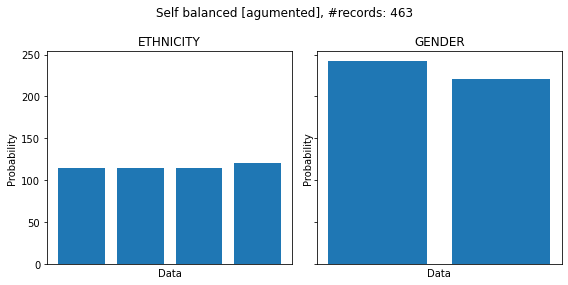

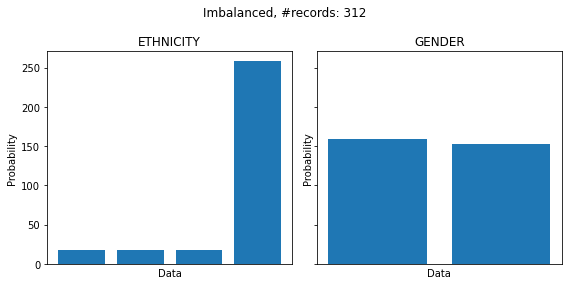

,experiment ID,f1,f1 variance,Avg. Disparate impact ratio,Avg. Statistical parity difference,Avg. Equal opportunity difference,Avg. Equal odd difference
0,Self balanced [agumented] White,0.129412,0.005677,0.596852,-0.047123,0.020833,0.008333
1,Imbalanced White,0.087838,0.000699,1.108584,0.055167,0.000000,0.000000


Server ready in 0.3724246025085449s
Workers ready in 77.77853488922119s
Workers registred in 0.001995086669921875s
Training complete in 57.23708438873291s
Server ready in 0.18894028663635254s
Workers ready in 4.704336881637573s
Workers registred in 0.0s
Training complete in 5.775828123092651s
Metrics evaluated in 9.03777813911438


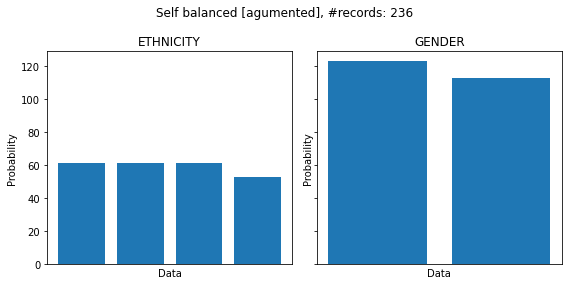

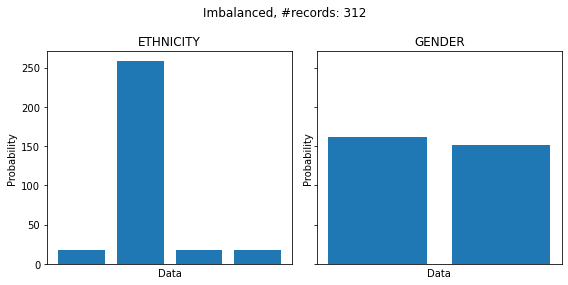

,experiment ID,f1,f1 variance,Avg. Disparate impact ratio,Avg. Statistical parity difference,Avg. Equal opportunity difference,Avg. Equal odd difference
0,Self balanced [agumented] Black,0.279630,0.008708,0.586640,-0.070012,-0.142262,-0.063066
1,Imbalanced Black,0.087838,0.000699,0.481545,-0.076701,0.000000,0.000000


Server ready in 0.16000080108642578s
Workers ready in 32.7269926071167s
Workers registred in 0.001001119613647461s
Training complete in 43.062134981155396s
Server ready in 0.16400885581970215s
Workers ready in 4.736100912094116s
Workers registred in 0.0s
Training complete in 5.808547019958496s
Metrics evaluated in 8.886817932128906


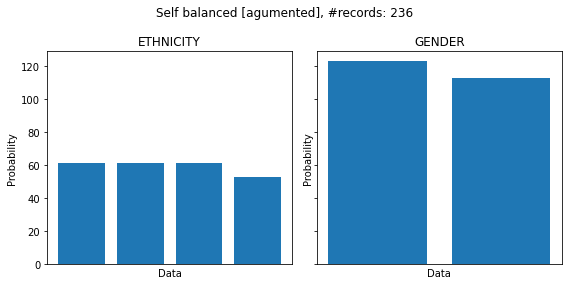

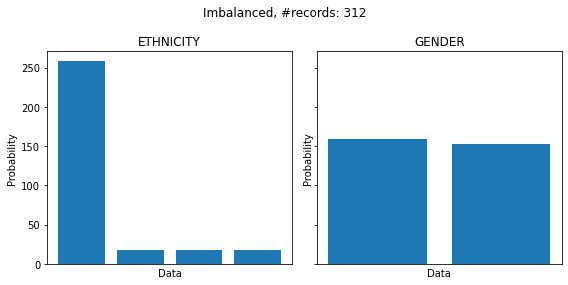

,experiment ID,f1,f1 variance,Avg. Disparate impact ratio,Avg. Statistical parity difference,Avg. Equal opportunity difference,Avg. Equal odd difference
0,Self balanced [agumented] Asian,0.479440,0.026535,0.726941,-0.012136,0.090327,0.044284
1,Imbalanced Asian,0.087838,0.000699,0.544249,-0.054145,0.000000,0.000000


Server ready in 0.16000008583068848s
Workers ready in 31.427700996398926s
Workers registred in 0.0s
Training complete in 31.57080101966858s
Server ready in 0.13199949264526367s
Workers ready in 3.5611517429351807s
Workers registred in 0.0020024776458740234s
Training complete in 4.141820907592773s
Metrics evaluated in 7.985117673873901


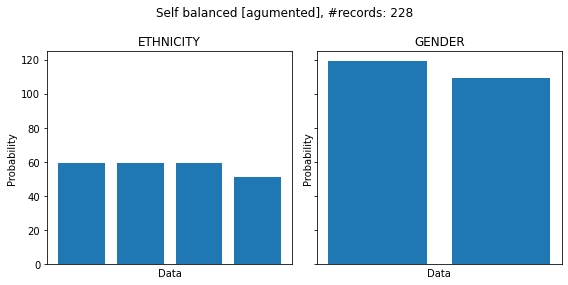

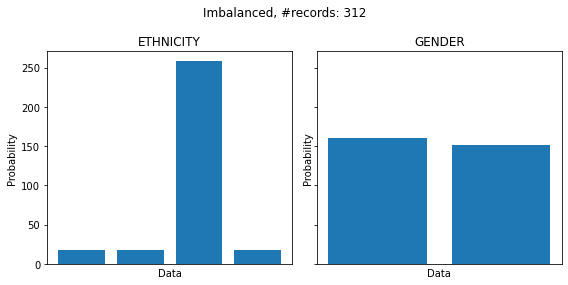

,experiment ID,f1,f1 variance,Avg. Disparate impact ratio,Avg. Statistical parity difference,Avg. Equal opportunity difference,Avg. Equal odd difference
0,Self balanced [agumented] Indian,0.504478,0.021827,0.871581,0.056738,-0.03497,-0.035033
1,Imbalanced Indian,0.087838,0.000699,1.317597,0.075680,0.00000,0.000000


<IPython.core.display.Javascript object>

In [29]:
%%notify
results = []
for i in range(len(p['ETHNICITIES'])):
    r = train_compare_pair_balanced_umbalanced(
            features,
            not_features,
            df,
            i, #numeric
            gap=p['gap'],
            max_gap=p['max_gap'],
            privileged_group_proportion=p['privileged_group_proportion']
        )
    results += [r]
    display(r)

### Display results

In [30]:
for r in results:
    display(r)
    print('')

,experiment ID,f1,f1 variance,Avg. Disparate impact ratio,Avg. Statistical parity difference,Avg. Equal opportunity difference,Avg. Equal odd difference
0,Self balanced [agumented] White,0.129412,0.005677,0.596852,-0.047123,0.020833,0.008333
1,Imbalanced White,0.087838,0.000699,1.108584,0.055167,0.000000,0.000000


,experiment ID,f1,f1 variance,Avg. Disparate impact ratio,Avg. Statistical parity difference,Avg. Equal opportunity difference,Avg. Equal odd difference
0,Self balanced [agumented] Black,0.279630,0.008708,0.586640,-0.070012,-0.142262,-0.063066
1,Imbalanced Black,0.087838,0.000699,0.481545,-0.076701,0.000000,0.000000


,experiment ID,f1,f1 variance,Avg. Disparate impact ratio,Avg. Statistical parity difference,Avg. Equal opportunity difference,Avg. Equal odd difference
0,Self balanced [agumented] Asian,0.479440,0.026535,0.726941,-0.012136,0.090327,0.044284
1,Imbalanced Asian,0.087838,0.000699,0.544249,-0.054145,0.000000,0.000000


,experiment ID,f1,f1 variance,Avg. Disparate impact ratio,Avg. Statistical parity difference,Avg. Equal opportunity difference,Avg. Equal odd difference
0,Self balanced [agumented] Indian,0.504478,0.021827,0.871581,0.056738,-0.03497,-0.035033
1,Imbalanced Indian,0.087838,0.000699,1.317597,0.075680,0.00000,0.000000
